# Language Translation
In this project, you’re going to take a peek into the realm of neural network machine translation.  You’ll be training a sequence to sequence model on a dataset of English and French sentences that can translate new sentences from English to French.
## Get the Data
Since translating the whole language of English to French will take lots of time to train, we have provided you with a small portion of the English corpus.

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import problem_unittests as tests

source_path = 'data/small_vocab_en'
target_path = 'data/small_vocab_fr'
source_text = helper.load_data(source_path)
target_text = helper.load_data(target_path)

## Explore the Data
Play around with view_sentence_range to view different parts of the data.

In [2]:
view_sentence_range = (0, 10)

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in source_text.split()})))

sentences = source_text.split('\n')
word_counts = [len(sentence.split()) for sentence in sentences]
print('Number of sentences: {}'.format(len(sentences)))
print('Average number of words in a sentence: {}'.format(np.average(word_counts)))

print()
print('English sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(source_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))
print()
print('French sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(target_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

Dataset Stats
Roughly the number of unique words: 227
Number of sentences: 137861
Average number of words in a sentence: 13.225277634719028

English sentences 0 to 10:
new jersey is sometimes quiet during autumn , and it is snowy in april .
the united states is usually chilly during july , and it is usually freezing in november .
california is usually quiet during march , and it is usually hot in june .
the united states is sometimes mild during june , and it is cold in september .
your least liked fruit is the grape , but my least liked is the apple .
his favorite fruit is the orange , but my favorite is the grape .
paris is relaxing during december , but it is usually chilly in july .
new jersey is busy during spring , and it is never hot in march .
our least liked fruit is the lemon , but my least liked is the grape .
the united states is sometimes busy during january , and it is sometimes warm in november .

French sentences 0 to 10:
new jersey est parfois calme pendant l' automne 

## Implement Preprocessing Function
### Text to Word Ids
As you did with other RNNs, you must turn the text into a number so the computer can understand it. In the function `text_to_ids()`, you'll turn `source_text` and `target_text` from words to ids.  However, you need to add the `<EOS>` word id at the end of `target_text`.  This will help the neural network predict when the sentence should end.

You can get the `<EOS>` word id by doing:
```python
target_vocab_to_int['<EOS>']
```
You can get other word ids using `source_vocab_to_int` and `target_vocab_to_int`.

In [3]:
def text_to_ids(source_text, target_text, source_vocab_to_int, target_vocab_to_int):
    """
    Convert source and target text to proper word ids
    :param source_text: String that contains all the source text.
    :param target_text: String that contains all the target text.
    :param source_vocab_to_int: Dictionary to go from the source words to an id
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: A tuple of lists (source_id_text, target_id_text)
    """
    # Use an ID of 0 if a word is not contained in source_vocab_to_int or target_vocab_to_int.
    source_id_text = [[source_vocab_to_int.get(w, 0) for w in s.split(' ')] for s in source_text.split('\n')]
       
    target_id_text = []
    for s in target_text.split('\n'):
        ids = [target_vocab_to_int.get(w, 0) for w in s.split(' ')]
        ids.append(target_vocab_to_int['<EOS>'])
        target_id_text.append(ids)
    
    return source_id_text, target_id_text

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_text_to_ids(text_to_ids)

Tests Passed


### Preprocess all the data and save it
Running the code cell below will preprocess all the data and save it to file.

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
helper.preprocess_and_save_data(source_path, target_path, text_to_ids)

# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import helper

(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
from tensorflow.python.layers.core import Dense

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.1'), 'Please use TensorFlow version 1.1 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/d065035/anaconda3/envs/tensorflow_1.1/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: No GPU found. Please use a GPU to train your neural network.


## Build the Neural Network
You'll build the components necessary to build a Sequence-to-Sequence model by implementing the following functions below:
- `model_inputs`
- `process_decoder_input`
- `encoding_layer`
- `decoding_layer_train`
- `decoding_layer_infer`
- `decoding_layer`
- `seq2seq_model`

### Input
Implement the `model_inputs()` function to create TF Placeholders for the Neural Network. It should create the following placeholders:

- Input text placeholder named "input" using the TF Placeholder name parameter with rank 2.
- Targets placeholder with rank 2.
- Learning rate placeholder with rank 0.
- Keep probability placeholder named "keep_prob" using the TF Placeholder name parameter with rank 0.
- Target sequence length placeholder named "target_sequence_length" with rank 1
- Max target sequence length tensor named "max_target_len" getting its value from applying tf.reduce_max on the target_sequence_length placeholder. Rank 0.
- Source sequence length placeholder named "source_sequence_length" with rank 1

Return the placeholders in the following the tuple (input, targets, learning rate, keep probability, target sequence length, max target sequence length, source sequence length)

In [7]:
def model_inputs():
    """
    Create TF Placeholders for input, targets, learning rate, and lengths of source and target sequences.
    :return: Tuple (input, targets, learning rate, keep probability, target sequence length,
    max target sequence length, source sequence length)
    """
    input_data = tf.placeholder(tf.int32, [None, None], name="input")
    targets = tf.placeholder(tf.int32, [None, None], name="targets")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    target_sequence_length = tf.placeholder(tf.int32, (None,), name="target_sequence_length")
    max_target_len = tf.reduce_max(target_sequence_length, name="max_target_len")
    source_sequence_length = tf.placeholder(tf.int32, (None,), name="source_sequence_length")
    
    return input_data, targets, learning_rate, keep_prob, target_sequence_length, max_target_len, source_sequence_length


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Process Decoder Input
Implement `process_decoder_input` by removing the last word id from each batch in `target_data` and concat the GO ID to the begining of each batch.

In [8]:
def process_decoder_input(target_data, target_vocab_to_int, batch_size):
    """
    Preprocess target data for encoding
    :param target_data: Target Placehoder
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param batch_size: Batch Size
    :return: Preprocessed target data
    """
    sliced = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    go = tf.fill([batch_size, 1], target_vocab_to_int['<GO>'])
    return tf.concat([go, sliced], 1)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_process_encoding_input(process_decoder_input)

Tests Passed


### Encoding
Implement `encoding_layer()` to create a Encoder RNN layer:
 * Embed the encoder input using [`tf.contrib.layers.embed_sequence`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence)
 * Construct a [stacked](https://github.com/tensorflow/tensorflow/blob/6947f65a374ebf29e74bb71e36fd82760056d82c/tensorflow/docs_src/tutorials/recurrent.md#stacking-multiple-lstms) [`tf.contrib.rnn.LSTMCell`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/LSTMCell) wrapped in a [`tf.contrib.rnn.DropoutWrapper`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/DropoutWrapper)
 * Pass cell and embedded input to [`tf.nn.dynamic_rnn()`](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn)

In [9]:
from imp import reload
reload(tests)

def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob, 
                   source_sequence_length, source_vocab_size, 
                   encoding_embedding_size):
    """
    Create encoding layer
    :param rnn_inputs: Inputs for the RNN
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param keep_prob: Dropout keep probability
    :param source_sequence_length: a list of the lengths of each sequence in the batch
    :param source_vocab_size: vocabulary size of source data
    :param encoding_embedding_size: embedding size of source data
    :return: tuple (RNN output, RNN state)
    """
    
    # Shape: [batch size, sequence length, embedding size]
    embedded_input = tf.contrib.layers.embed_sequence(ids=rnn_inputs,
                                                      vocab_size=source_vocab_size,
                                                      embed_dim=encoding_embedding_size)
    
    def lstm_cell(num_units):
        cell = tf.contrib.rnn.LSTMCell(num_units=num_units,
                                       initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
        return tf.contrib.rnn.DropoutWrapper(cell=cell, input_keep_prob=keep_prob)
    
    lstm_cells = [lstm_cell(rnn_size) for _ in range(num_layers)]
    rnn_cells = tf.contrib.rnn.MultiRNNCell(cells=lstm_cells)
    
    output, state = tf.nn.dynamic_rnn(cell=rnn_cells,
                                      inputs=embedded_input,
                                      sequence_length=source_sequence_length,
                                      dtype=tf.float32)
    return output, state


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_encoding_layer(encoding_layer)

Tests Passed


### Decoding - Training
Create a training decoding layer:
* Create a [`tf.contrib.seq2seq.TrainingHelper`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/TrainingHelper) 
* Create a [`tf.contrib.seq2seq.BasicDecoder`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/BasicDecoder)
* Obtain the decoder outputs from [`tf.contrib.seq2seq.dynamic_decode`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_decode)

In [10]:

def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, 
                         target_sequence_length, max_target_sequence_length, 
                         output_layer, keep_prob):
    """
    Create a decoding layer for training
    :param encoder_state: Encoder State
    :param dec_cell: Decoder RNN Cell
    :param dec_embed_input: Decoder embedded input
    :param target_sequence_length: The lengths of each sequence in the target batch
    :param max_target_sequence_length: The length of the longest sequence in the batch
    :param output_layer: Function to apply the output layer
    :param keep_prob: Dropout keep probability
    :return: BasicDecoderOutput containing training logits and sample_id
    """
    
    # I don't know how to use keep_prob here. Is it required?
    
    training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input, 
                                                        sequence_length=target_sequence_length)
    
    training_decoder = tf.contrib.seq2seq.BasicDecoder(cell=dec_cell,
                                                       helper=training_helper,
                                                       initial_state=encoder_state,
                                                       output_layer=output_layer)
    
    training_logits, _ = tf.contrib.seq2seq.dynamic_decode(decoder=training_decoder,
                                                           impute_finished=True,
                                                           maximum_iterations=max_target_sequence_length)
    
    return training_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_train(decoding_layer_train)

Tests Passed


### Decoding - Inference
Create inference decoder:
* Create a [`tf.contrib.seq2seq.GreedyEmbeddingHelper`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/GreedyEmbeddingHelper)
* Create a [`tf.contrib.seq2seq.BasicDecoder`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/BasicDecoder)
* Obtain the decoder outputs from [`tf.contrib.seq2seq.dynamic_decode`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_decode)

In [11]:
def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id,
                         end_of_sequence_id, max_target_sequence_length,
                         vocab_size, output_layer, batch_size, keep_prob):
    """
    Create a decoding layer for inference
    :param encoder_state: Encoder state
    :param dec_cell: Decoder RNN Cell
    :param dec_embeddings: Decoder embeddings
    :param start_of_sequence_id: GO ID
    :param end_of_sequence_id: EOS Id
    :param max_target_sequence_length: Maximum length of target sequences
    :param vocab_size: Size of decoder/target vocabulary
    :param decoding_scope: TenorFlow Variable Scope for decoding
    :param output_layer: Function to apply the output layer
    :param batch_size: Batch size
    :param keep_prob: Dropout keep probability
    :return: BasicDecoderOutput containing inference logits and sample_id
    """
    
    # I don't know how to use keep_prob here. Is it required?
    
    start_token=tf.constant([start_of_sequence_id], dtype=tf.int32)
    start_tokens=tf.tile(start_token, [batch_size], name="start_tokens")
    
    inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(embedding=dec_embeddings,
                                                                start_tokens=start_tokens,
                                                                end_token=end_of_sequence_id)
    
    inference_decoder = tf.contrib.seq2seq.BasicDecoder(cell=dec_cell,
                                                        helper=inference_helper,
                                                        initial_state=encoder_state,
                                                        output_layer=output_layer)
    
    inference_logits, _ = tf.contrib.seq2seq.dynamic_decode(decoder=inference_decoder,
                                                            impute_finished=True,
                                                            maximum_iterations=max_target_sequence_length)
    
    return inference_logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_infer(decoding_layer_infer)

Tests Passed


### Build the Decoding Layer
Implement `decoding_layer()` to create a Decoder RNN layer.

* Embed the target sequences
* Construct the decoder LSTM cell (just like you constructed the encoder cell above)
* Create an output layer to map the outputs of the decoder to the elements of our vocabulary
* Use the your `decoding_layer_train(encoder_state, dec_cell, dec_embed_input, target_sequence_length, max_target_sequence_length, output_layer, keep_prob)` function to get the training logits.
* Use your `decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id, max_target_sequence_length, vocab_size, output_layer, batch_size, keep_prob)` function to get the inference logits.

Note: You'll need to use [tf.variable_scope](https://www.tensorflow.org/api_docs/python/tf/variable_scope) to share variables between training and inference.

In [12]:
def decoding_layer(dec_input, encoder_state,
                   target_sequence_length, max_target_sequence_length,
                   rnn_size,
                   num_layers, target_vocab_to_int, target_vocab_size,
                   batch_size, keep_prob, decoding_embedding_size):
    """
    Create decoding layer
    :param dec_input: Decoder input
    :param encoder_state: Encoder state
    :param target_sequence_length: The lengths of each sequence in the target batch
    :param max_target_sequence_length: Maximum length of target sequences
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param target_vocab_size: Size of target vocabulary
    :param batch_size: The size of the batch
    :param keep_prob: Dropout keep probability
    :param decoding_embedding_size: Decoding embedding size
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """ 
    
    # Embed the target sequences.
    # ---------------------------
    # Shape: [vocab_size, embedding_size]
    embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
    # Shape: [batch_size, sequence_length, embedding_size]
    embedding_lookup = tf.nn.embedding_lookup(params=embeddings, ids=dec_input)
        
    # Construct the decoder LSTM cells.
    # ---------------------------------
    def lstm_cell(num_units):
        cell = tf.contrib.rnn.LSTMCell(num_units=num_units,
                                       initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
        return tf.contrib.rnn.DropoutWrapper(cell=cell, input_keep_prob=keep_prob)
    
    lstm_cells = [lstm_cell(rnn_size) for _ in range(num_layers)]
    rnn_cells = tf.contrib.rnn.MultiRNNCell(cells=lstm_cells)
    
    # Create an output layer.
    # -----------------------
    output_layer = Dense(units=target_vocab_size,
                         kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
    
    # Get the training logits.
    # ------------------------
    with tf.variable_scope("decode"):
        trainig_logits = decoding_layer_train(encoder_state=encoder_state,
                                              dec_cell=rnn_cells,
                                              dec_embed_input=embedding_lookup,
                                              target_sequence_length=target_sequence_length,
                                              max_target_sequence_length=max_target_sequence_length,
                                              output_layer=output_layer,
                                              keep_prob=keep_prob)
    
    # Get the inference logits.
    # -------------------------
    with tf.variable_scope("decode", reuse=True):
        inference_logits = decoding_layer_infer(encoder_state=encoder_state,
                                                dec_cell=rnn_cells,
                                                dec_embeddings=embeddings,
                                                start_of_sequence_id=target_vocab_to_int["<GO>"],
                                                end_of_sequence_id=target_vocab_to_int["<EOS>"],
                                                max_target_sequence_length=max_target_sequence_length,
                                                vocab_size=target_vocab_size,
                                                output_layer=output_layer,
                                                batch_size=batch_size,
                                                keep_prob=keep_prob)

    
    return trainig_logits, inference_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer(decoding_layer)

Tests Passed


### Build the Neural Network
Apply the functions you implemented above to:

- Encode the input using your `encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob,  source_sequence_length, source_vocab_size, encoding_embedding_size)`.
- Process target data using your `process_decoder_input(target_data, target_vocab_to_int, batch_size)` function.
- Decode the encoded input using your `decoding_layer(dec_input, enc_state, target_sequence_length, max_target_sentence_length, rnn_size, num_layers, target_vocab_to_int, target_vocab_size, batch_size, keep_prob, dec_embedding_size)` function.

In [13]:
def seq2seq_model(input_data, target_data, keep_prob, batch_size,
                  source_sequence_length, target_sequence_length,
                  max_target_sentence_length,
                  source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size,
                  rnn_size, num_layers, target_vocab_to_int):
    """
    Build the Sequence-to-Sequence part of the neural network.
    :param input_data: Input placeholder.
    :param target_data: Target placeholder.
    :param keep_prob: Dropout keep probability placeholder.
    :param batch_size: Batch size.
    :param source_sequence_length: Sequence lengths of source sequences in the batch.
    :param target_sequence_length: Sequence lengths of target sequences in the batch.
    :param source_vocab_size: Source vocabulary size.
    :param target_vocab_size: Target vocabulary size.
    :param enc_embedding_size: Decoder embedding size.
    :param dec_embedding_size: Encoder embedding size.
    :param rnn_size: RNN size.
    :param num_layers: Number of layers.
    :param target_vocab_to_int: Dictionary to go from target words to IDs.
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """
    
    print("input_data: {}".format(input_data))  # Shape: [batch_size, sequence_length]
    print("target_data: {}".format(input_data))  # Shape: [batch_size, sequence_length]
    print("keep_prob: {}".format(keep_prob))
    print("batch_size: {}".format(batch_size))    
    print("source_sequence_length: {}".format(source_sequence_length))
    print("target_sequence_length: {}".format(target_sequence_length))
    print("source_vocab_size: {}".format(source_vocab_size))
    print("target_vocab_size: {}".format(target_vocab_size))
    print("enc_embedding_size: {}".format(enc_embedding_size)) 
    print("dec_embedding_size: {}".format(dec_embedding_size)) 
    print("rnn_size: {}".format(rnn_size))
    print("num_layers: {}".format(num_layers))
    
    # Encode the input.
    encoder_output, encoder_state = encoding_layer(rnn_inputs=input_data,
                                                   rnn_size=rnn_size,
                                                   num_layers=num_layers,
                                                   keep_prob=keep_prob,
                                                   source_sequence_length=source_sequence_length,
                                                   source_vocab_size=source_vocab_size,
                                                   encoding_embedding_size=enc_embedding_size)
    
    # Process the target data.    
    decoder_input = process_decoder_input(target_data=target_data,
                                          target_vocab_to_int=target_vocab_to_int,
                                          batch_size=batch_size)
        
    # Decode the encoded input.                    
    training_logits, inference_logits = decoding_layer(dec_input=decoder_input,
                                                       encoder_state=encoder_state,
                                                       target_sequence_length=target_sequence_length,
                                                       max_target_sequence_length=max_target_sentence_length,
                                                       rnn_size=rnn_size,
                                                       num_layers=num_layers,
                                                       target_vocab_to_int=target_vocab_to_int,
                                                       target_vocab_size=target_vocab_size,
                                                       batch_size=batch_size,
                                                       keep_prob=keep_prob,
                                                       decoding_embedding_size=dec_embedding_size)    
    
    return training_logits, inference_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_seq2seq_model(seq2seq_model)

input_data: Tensor("Placeholder_6:0", shape=(64, 22), dtype=int32)
target_data: Tensor("Placeholder_6:0", shape=(64, 22), dtype=int32)
keep_prob: Tensor("Placeholder_8:0", dtype=float32)
batch_size: 64
source_sequence_length: Tensor("source_sequence_length:0", shape=(?,), dtype=int32)
target_sequence_length: Tensor("target_sequence_length:0", shape=(?,), dtype=int32)
source_vocab_size: 300
target_vocab_size: 300
enc_embedding_size: 100
dec_embedding_size: 100
rnn_size: 512
num_layers: 3
Tests Passed


## Neural Network Training
### Hyperparameters
Tune the following parameters:

- Set `epochs` to the number of epochs.
- Set `batch_size` to the batch size.
- Set `rnn_size` to the size of the RNNs.
- Set `num_layers` to the number of layers.
- Set `encoding_embedding_size` to the size of the embedding for the encoder.
- Set `decoding_embedding_size` to the size of the embedding for the decoder.
- Set `learning_rate` to the learning rate.
- Set `keep_probability` to the Dropout keep probability
- Set `display_step` to state how many steps between each debug output statement

In [14]:
# Number of epochs.
epochs = 30

# Batch size.
batch_size = 128

# RNN size, i.e. the number of hidden units in the LSTM cells.
rnn_size = 64

# Number of LSTM layers.
num_layers = 2

# Embedding sizes.
# I read somewhere that the embedding size should be bigger than the RNN size.
# I'm using double the number of hidden units in the LSTMs.
encoding_embedding_size = 128
decoding_embedding_size = 128

# Learning rate.
learning_rate = 0.001

# Dropout keep probability.
keep_probability = 0.6

# How many steps between each debug statement?
display_step = 51

### Build the Graph
Build the graph using the neural network you implemented.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_path = 'checkpoints/dev'
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()
max_target_sentence_length = max([len(sentence) for sentence in source_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, lr, keep_prob, target_sequence_length, max_target_sequence_length, source_sequence_length = model_inputs()

    #sequence_length = tf.placeholder_with_default(max_target_sentence_length, None, name='sequence_length')
    input_shape = tf.shape(input_data)

    train_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]),
                                                   targets,
                                                   keep_prob,
                                                   batch_size,
                                                   source_sequence_length,
                                                   target_sequence_length,
                                                   max_target_sequence_length,
                                                   len(source_vocab_to_int),
                                                   len(target_vocab_to_int),
                                                   encoding_embedding_size,
                                                   decoding_embedding_size,
                                                   rnn_size,
                                                   num_layers,
                                                   target_vocab_to_int)


    training_logits = tf.identity(train_logits.rnn_output, name='logits')
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')

    masks = tf.sequence_mask(target_sequence_length, max_target_sequence_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)


input_data: Tensor("ReverseV2:0", shape=(?, ?), dtype=int32)
target_data: Tensor("ReverseV2:0", shape=(?, ?), dtype=int32)
keep_prob: Tensor("keep_prob:0", dtype=float32)
batch_size: 128
source_sequence_length: Tensor("source_sequence_length:0", shape=(?,), dtype=int32)
target_sequence_length: Tensor("target_sequence_length:0", shape=(?,), dtype=int32)
source_vocab_size: 231
target_vocab_size: 358
enc_embedding_size: 128
dec_embedding_size: 128
rnn_size: 64
num_layers: 2


Batch and pad the source and target sequences

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
def pad_sentence_batch(sentence_batch, pad_int):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [pad_int] * (max_sentence - len(sentence)) for sentence in sentence_batch]


def get_batches(sources, targets, batch_size, source_pad_int, target_pad_int):
    """Batch targets, sources, and the lengths of their sentences together"""
    for batch_i in range(0, len(sources)//batch_size):
        start_i = batch_i * batch_size

        # Slice the right amount for the batch
        sources_batch = sources[start_i:start_i + batch_size]
        targets_batch = targets[start_i:start_i + batch_size]

        # Pad
        pad_sources_batch = np.array(pad_sentence_batch(sources_batch, source_pad_int))
        pad_targets_batch = np.array(pad_sentence_batch(targets_batch, target_pad_int))

        # Need the lengths for the _lengths parameters
        pad_targets_lengths = []
        for target in pad_targets_batch:
            pad_targets_lengths.append(len(target))

        pad_source_lengths = []
        for source in pad_sources_batch:
            pad_source_lengths.append(len(source))

        yield pad_sources_batch, pad_targets_batch, pad_source_lengths, pad_targets_lengths


### Train
Train the neural network on the preprocessed data. If you have a hard time getting a good loss, check the forms to see if anyone is having the same problem.

In [17]:
# I'm addinga few things to plot the loss and test/validation accuracies.
# See the START and END delimiters.

# ----- START ----- #
%matplotlib inline

import matplotlib.pyplot as plt

batches = []
losses = []
train_accs = []
valid_accs = []
# ----- END ----- #

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
def get_accuracy(target, logits):
    """
    Calculate accuracy
    """
    max_seq = max(target.shape[1], logits.shape[1])
    if max_seq - target.shape[1]:
        target = np.pad(
            target,
            [(0,0),(0,max_seq - target.shape[1])],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1])],
            'constant')

    return np.mean(np.equal(target, logits))

# Split data to training and validation sets
train_source = source_int_text[batch_size:]
train_target = target_int_text[batch_size:]
valid_source = source_int_text[:batch_size]
valid_target = target_int_text[:batch_size]
(valid_sources_batch, valid_targets_batch, valid_sources_lengths, valid_targets_lengths ) = next(get_batches(valid_source,
                                                                                                             valid_target,
                                                                                                             batch_size,
                                                                                                             source_vocab_to_int['<PAD>'],
                                                                                                             target_vocab_to_int['<PAD>']))                                                                                                  
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(epochs):
        for batch_i, (source_batch, target_batch, sources_lengths, targets_lengths) in enumerate(
                get_batches(train_source, train_target, batch_size,
                            source_vocab_to_int['<PAD>'],
                            target_vocab_to_int['<PAD>'])):

            _, loss = sess.run(
                [train_op, cost],
                {input_data: source_batch,
                 targets: target_batch,
                 lr: learning_rate,
                 target_sequence_length: targets_lengths,
                 source_sequence_length: sources_lengths,
                 keep_prob: keep_probability})


            if batch_i % display_step == 0 and batch_i > 0:

                batch_train_logits = sess.run(
                    inference_logits,
                    {input_data: source_batch,
                     source_sequence_length: sources_lengths,
                     target_sequence_length: targets_lengths,
                     keep_prob: 1.0})


                batch_valid_logits = sess.run(
                    inference_logits,
                    {input_data: valid_sources_batch,
                     source_sequence_length: valid_sources_lengths,
                     target_sequence_length: valid_targets_lengths,
                     keep_prob: 1.0})

                train_acc = get_accuracy(target_batch, batch_train_logits)

                valid_acc = get_accuracy(valid_targets_batch, batch_valid_logits)

                # ----- START ----- #
                previous_batch = batches[-1] if batches else 0
                batches.append(display_step + previous_batch)
                losses.append(loss)
                train_accs.append(train_acc)
                valid_accs.append(valid_acc)
                # ----- END ----- #

                print('Epoch {:>3} Batch {:>4}/{} - Train Accuracy: {:>6.4f}, Validation Accuracy: {:>6.4f}, Loss: {:>6.4f}'
                      .format(epoch_i, batch_i, len(source_int_text) // batch_size, train_acc, valid_acc, loss))

    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_path)

    print('Model Trained and Saved')

Epoch   0 Batch   51/1077 - Train Accuracy: 0.3230, Validation Accuracy: 0.3651, Loss: 3.2784
Epoch   0 Batch  102/1077 - Train Accuracy: 0.3461, Validation Accuracy: 0.3814, Loss: 2.9182
Epoch   0 Batch  153/1077 - Train Accuracy: 0.3527, Validation Accuracy: 0.4137, Loss: 2.8297
Epoch   0 Batch  204/1077 - Train Accuracy: 0.3852, Validation Accuracy: 0.4414, Loss: 2.6037
Epoch   0 Batch  255/1077 - Train Accuracy: 0.4164, Validation Accuracy: 0.4734, Loss: 2.4771
Epoch   0 Batch  306/1077 - Train Accuracy: 0.4323, Validation Accuracy: 0.4709, Loss: 2.2497
Epoch   0 Batch  357/1077 - Train Accuracy: 0.4799, Validation Accuracy: 0.4840, Loss: 2.0700
Epoch   0 Batch  408/1077 - Train Accuracy: 0.4422, Validation Accuracy: 0.4911, Loss: 2.1031
Epoch   0 Batch  459/1077 - Train Accuracy: 0.4914, Validation Accuracy: 0.5099, Loss: 1.8805
Epoch   0 Batch  510/1077 - Train Accuracy: 0.4707, Validation Accuracy: 0.5096, Loss: 1.7711
Epoch   0 Batch  561/1077 - Train Accuracy: 0.4766, Validati

Epoch   4 Batch  255/1077 - Train Accuracy: 0.8039, Validation Accuracy: 0.7823, Loss: 0.2946
Epoch   4 Batch  306/1077 - Train Accuracy: 0.8225, Validation Accuracy: 0.7901, Loss: 0.2913
Epoch   4 Batch  357/1077 - Train Accuracy: 0.8185, Validation Accuracy: 0.8089, Loss: 0.2881
Epoch   4 Batch  408/1077 - Train Accuracy: 0.7957, Validation Accuracy: 0.8050, Loss: 0.2895
Epoch   4 Batch  459/1077 - Train Accuracy: 0.8274, Validation Accuracy: 0.8207, Loss: 0.2602
Epoch   4 Batch  510/1077 - Train Accuracy: 0.8070, Validation Accuracy: 0.7969, Loss: 0.2759
Epoch   4 Batch  561/1077 - Train Accuracy: 0.8307, Validation Accuracy: 0.7955, Loss: 0.2543
Epoch   4 Batch  612/1077 - Train Accuracy: 0.8352, Validation Accuracy: 0.8029, Loss: 0.2606
Epoch   4 Batch  663/1077 - Train Accuracy: 0.8332, Validation Accuracy: 0.8100, Loss: 0.2417
Epoch   4 Batch  714/1077 - Train Accuracy: 0.8635, Validation Accuracy: 0.8267, Loss: 0.2458
Epoch   4 Batch  765/1077 - Train Accuracy: 0.8371, Validati

Epoch   8 Batch  459/1077 - Train Accuracy: 0.9156, Validation Accuracy: 0.9070, Loss: 0.0967
Epoch   8 Batch  510/1077 - Train Accuracy: 0.9059, Validation Accuracy: 0.8963, Loss: 0.1005
Epoch   8 Batch  561/1077 - Train Accuracy: 0.9141, Validation Accuracy: 0.8974, Loss: 0.0927
Epoch   8 Batch  612/1077 - Train Accuracy: 0.9401, Validation Accuracy: 0.8967, Loss: 0.0880
Epoch   8 Batch  663/1077 - Train Accuracy: 0.9395, Validation Accuracy: 0.9148, Loss: 0.0788
Epoch   8 Batch  714/1077 - Train Accuracy: 0.9196, Validation Accuracy: 0.8977, Loss: 0.0975
Epoch   8 Batch  765/1077 - Train Accuracy: 0.9172, Validation Accuracy: 0.8991, Loss: 0.0933
Epoch   8 Batch  816/1077 - Train Accuracy: 0.9494, Validation Accuracy: 0.8970, Loss: 0.1025
Epoch   8 Batch  867/1077 - Train Accuracy: 0.8957, Validation Accuracy: 0.8999, Loss: 0.1282
Epoch   8 Batch  918/1077 - Train Accuracy: 0.9033, Validation Accuracy: 0.8945, Loss: 0.0907
Epoch   8 Batch  969/1077 - Train Accuracy: 0.8895, Validati

Epoch  12 Batch  663/1077 - Train Accuracy: 0.9531, Validation Accuracy: 0.9371, Loss: 0.0445
Epoch  12 Batch  714/1077 - Train Accuracy: 0.9531, Validation Accuracy: 0.9286, Loss: 0.0493
Epoch  12 Batch  765/1077 - Train Accuracy: 0.9184, Validation Accuracy: 0.9386, Loss: 0.0568
Epoch  12 Batch  816/1077 - Train Accuracy: 0.9613, Validation Accuracy: 0.9442, Loss: 0.0578
Epoch  12 Batch  867/1077 - Train Accuracy: 0.9262, Validation Accuracy: 0.9478, Loss: 0.0865
Epoch  12 Batch  918/1077 - Train Accuracy: 0.9263, Validation Accuracy: 0.9332, Loss: 0.0537
Epoch  12 Batch  969/1077 - Train Accuracy: 0.9029, Validation Accuracy: 0.9244, Loss: 0.0592
Epoch  12 Batch 1020/1077 - Train Accuracy: 0.9617, Validation Accuracy: 0.9371, Loss: 0.0436
Epoch  12 Batch 1071/1077 - Train Accuracy: 0.9301, Validation Accuracy: 0.9339, Loss: 0.0443
Epoch  13 Batch   51/1077 - Train Accuracy: 0.9227, Validation Accuracy: 0.9432, Loss: 0.0485
Epoch  13 Batch  102/1077 - Train Accuracy: 0.9371, Validati

Epoch  16 Batch  867/1077 - Train Accuracy: 0.9328, Validation Accuracy: 0.9563, Loss: 0.0699
Epoch  16 Batch  918/1077 - Train Accuracy: 0.9572, Validation Accuracy: 0.9560, Loss: 0.0358
Epoch  16 Batch  969/1077 - Train Accuracy: 0.9327, Validation Accuracy: 0.9421, Loss: 0.0542
Epoch  16 Batch 1020/1077 - Train Accuracy: 0.9719, Validation Accuracy: 0.9553, Loss: 0.0305
Epoch  16 Batch 1071/1077 - Train Accuracy: 0.9398, Validation Accuracy: 0.9595, Loss: 0.0393
Epoch  17 Batch   51/1077 - Train Accuracy: 0.9527, Validation Accuracy: 0.9556, Loss: 0.0375
Epoch  17 Batch  102/1077 - Train Accuracy: 0.9414, Validation Accuracy: 0.9542, Loss: 0.0418
Epoch  17 Batch  153/1077 - Train Accuracy: 0.9453, Validation Accuracy: 0.9350, Loss: 0.0465
Epoch  17 Batch  204/1077 - Train Accuracy: 0.9375, Validation Accuracy: 0.9531, Loss: 0.0521
Epoch  17 Batch  255/1077 - Train Accuracy: 0.9516, Validation Accuracy: 0.9613, Loss: 0.0413
Epoch  17 Batch  306/1077 - Train Accuracy: 0.9635, Validati

Epoch  20 Batch 1071/1077 - Train Accuracy: 0.9668, Validation Accuracy: 0.9606, Loss: 0.0317
Epoch  21 Batch   51/1077 - Train Accuracy: 0.9539, Validation Accuracy: 0.9688, Loss: 0.0383
Epoch  21 Batch  102/1077 - Train Accuracy: 0.9805, Validation Accuracy: 0.9638, Loss: 0.0310
Epoch  21 Batch  153/1077 - Train Accuracy: 0.9410, Validation Accuracy: 0.9567, Loss: 0.0378
Epoch  21 Batch  204/1077 - Train Accuracy: 0.9500, Validation Accuracy: 0.9553, Loss: 0.0529
Epoch  21 Batch  255/1077 - Train Accuracy: 0.9516, Validation Accuracy: 0.9528, Loss: 0.0347
Epoch  21 Batch  306/1077 - Train Accuracy: 0.9647, Validation Accuracy: 0.9609, Loss: 0.0405
Epoch  21 Batch  357/1077 - Train Accuracy: 0.9650, Validation Accuracy: 0.9585, Loss: 0.0332
Epoch  21 Batch  408/1077 - Train Accuracy: 0.9684, Validation Accuracy: 0.9489, Loss: 0.0305
Epoch  21 Batch  459/1077 - Train Accuracy: 0.9565, Validation Accuracy: 0.9659, Loss: 0.0374
Epoch  21 Batch  510/1077 - Train Accuracy: 0.9516, Validati

Epoch  25 Batch  204/1077 - Train Accuracy: 0.9527, Validation Accuracy: 0.9570, Loss: 0.0462
Epoch  25 Batch  255/1077 - Train Accuracy: 0.9555, Validation Accuracy: 0.9684, Loss: 0.0273
Epoch  25 Batch  306/1077 - Train Accuracy: 0.9673, Validation Accuracy: 0.9634, Loss: 0.0372
Epoch  25 Batch  357/1077 - Train Accuracy: 0.9632, Validation Accuracy: 0.9620, Loss: 0.0313
Epoch  25 Batch  408/1077 - Train Accuracy: 0.9746, Validation Accuracy: 0.9652, Loss: 0.0301
Epoch  25 Batch  459/1077 - Train Accuracy: 0.9680, Validation Accuracy: 0.9702, Loss: 0.0292
Epoch  25 Batch  510/1077 - Train Accuracy: 0.9656, Validation Accuracy: 0.9684, Loss: 0.0255
Epoch  25 Batch  561/1077 - Train Accuracy: 0.9635, Validation Accuracy: 0.9656, Loss: 0.0233
Epoch  25 Batch  612/1077 - Train Accuracy: 0.9661, Validation Accuracy: 0.9613, Loss: 0.0255
Epoch  25 Batch  663/1077 - Train Accuracy: 0.9637, Validation Accuracy: 0.9602, Loss: 0.0277
Epoch  25 Batch  714/1077 - Train Accuracy: 0.9866, Validati

Epoch  29 Batch  408/1077 - Train Accuracy: 0.9820, Validation Accuracy: 0.9670, Loss: 0.0285
Epoch  29 Batch  459/1077 - Train Accuracy: 0.9702, Validation Accuracy: 0.9592, Loss: 0.0272
Epoch  29 Batch  510/1077 - Train Accuracy: 0.9652, Validation Accuracy: 0.9659, Loss: 0.0239
Epoch  29 Batch  561/1077 - Train Accuracy: 0.9695, Validation Accuracy: 0.9592, Loss: 0.0247
Epoch  29 Batch  612/1077 - Train Accuracy: 0.9829, Validation Accuracy: 0.9624, Loss: 0.0220
Epoch  29 Batch  663/1077 - Train Accuracy: 0.9719, Validation Accuracy: 0.9549, Loss: 0.0227
Epoch  29 Batch  714/1077 - Train Accuracy: 0.9862, Validation Accuracy: 0.9609, Loss: 0.0284
Epoch  29 Batch  765/1077 - Train Accuracy: 0.9520, Validation Accuracy: 0.9663, Loss: 0.0339
Epoch  29 Batch  816/1077 - Train Accuracy: 0.9741, Validation Accuracy: 0.9609, Loss: 0.0269
Epoch  29 Batch  867/1077 - Train Accuracy: 0.9246, Validation Accuracy: 0.9762, Loss: 0.0529
Epoch  29 Batch  918/1077 - Train Accuracy: 0.9836, Validati

# Batches: 630


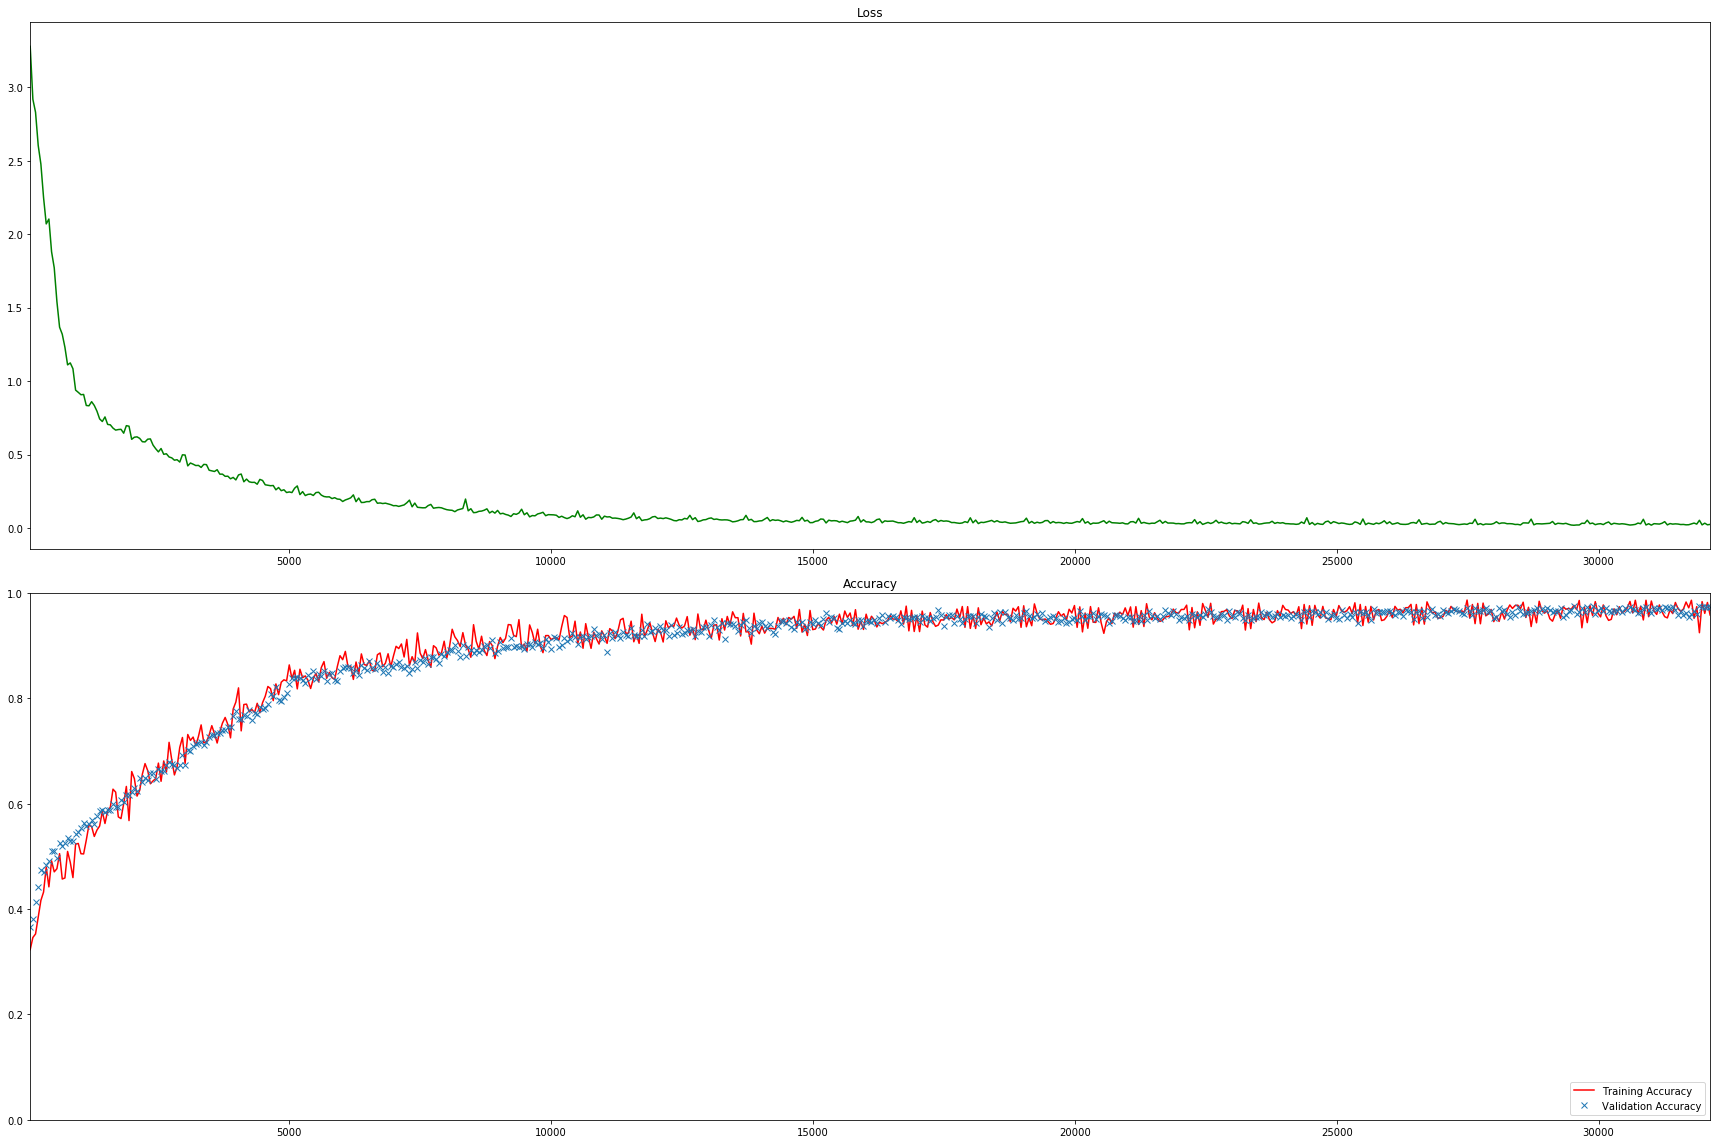

In [18]:
# Print the loss and test/validation accuracies.

# Increase size of the subplots.
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 24 
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size

# ----- START ----- #
print("# Batches: {}".format(len(batches)))
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, losses, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])

acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_accs, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_accs, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)

plt.tight_layout()
plt.show()
# ----- END ----- #


### Save Parameters
Save the `batch_size` and `save_path` parameters for inference.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Save parameters for checkpoint
helper.save_params(save_path)

# Checkpoint

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import tensorflow as tf
import numpy as np
import helper
import problem_unittests as tests

_, (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab, target_int_to_vocab) = helper.load_preprocess()
load_path = helper.load_params()

## Sentence to Sequence
To feed a sentence into the model for translation, you first need to preprocess it.  Implement the function `sentence_to_seq()` to preprocess new sentences.

- Convert the sentence to lowercase
- Convert words into ids using `vocab_to_int`
 - Convert words not in the vocabulary, to the `<UNK>` word id.

In [21]:
def sentence_to_seq(sentence, vocab_to_int):
    """
    Convert a sentence to a sequence of ids
    :param sentence: String
    :param vocab_to_int: Dictionary to go from the words to an id
    :return: List of word ids
    """
    unk_id = vocab_to_int['<UNK>']
    return [vocab_to_int.get(w, unk_id) for w in sentence.lower().split(' ')]


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_sentence_to_seq(sentence_to_seq)

Tests Passed


## Translate
This will translate `translate_sentence` from English to French.

In [22]:
translate_sentence = 'he saw a old black truck .'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
translate_sentence = sentence_to_seq(translate_sentence, source_vocab_to_int)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_path + '.meta')
    loader.restore(sess, load_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    target_sequence_length = loaded_graph.get_tensor_by_name('target_sequence_length:0')
    source_sequence_length = loaded_graph.get_tensor_by_name('source_sequence_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    translate_logits = sess.run(logits, {input_data: [translate_sentence]*batch_size,
                                         target_sequence_length: [len(translate_sentence)*2]*batch_size,
                                         source_sequence_length: [len(translate_sentence)]*batch_size,
                                         keep_prob: 1.0})[0]

print('Input')
print('  Word Ids:      {}'.format([i for i in translate_sentence]))
print('  English Words: {}'.format([source_int_to_vocab[i] for i in translate_sentence]))

print('\nPrediction')
print('  Word Ids:      {}'.format([i for i in translate_logits]))
print('  French Words: {}'.format(" ".join([target_int_to_vocab[i] for i in translate_logits])))


INFO:tensorflow:Restoring parameters from checkpoints/dev
Input
  Word Ids:      [59, 29, 126, 35, 43, 94, 24]
  English Words: ['he', 'saw', 'a', 'old', 'black', 'truck', '.']

Prediction
  Word Ids:      [117, 230, 331, 198, 340, 48, 68, 288, 1]
  French Words: il a vu un vieux camion noir . <EOS>


## Imperfect Translation
You might notice that some sentences translate better than others.  Since the dataset you're using only has a vocabulary of 227 English words of the thousands that you use, you're only going to see good results using these words.  For this project, you don't need a perfect translation. However, if you want to create a better translation model, you'll need better data.

You can train on the [WMT10 French-English corpus](http://www.statmt.org/wmt10/training-giga-fren.tar).  This dataset has more vocabulary and richer in topics discussed.  However, this will take you days to train, so make sure you've a GPU and the neural network is performing well on dataset we provided.  Just make sure you play with the WMT10 corpus after you've submitted this project.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_language_translation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.